In [ ]:
# default_exp core

# Importing sequences of Images

> We will do some things here and there

In [ ]:
#export
from fastai2.vision.all import *

In [ ]:
#export
PATH = Path.cwd().parent/'data'
Path.BASE_PATH = PATH

IMAGE_PATH = PATH/'UCF-101-frames'
SPLIT_PATH = PATH/'ucfTrainTestlist'

Let's grab a folder full of frames:

In [ ]:
video = IMAGE_PATH.ls()[0].ls()[0]
video

Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01')

In [ ]:
video.ls().sorted()

(#163) [Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/0.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/1.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/10.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/100.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/101.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/102.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/103.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/104.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/105.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/106.jpg')...]

Each frame is an image:

In [ ]:
frame = video.ls()[0]

In [ ]:
frame

Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/83.jpg')

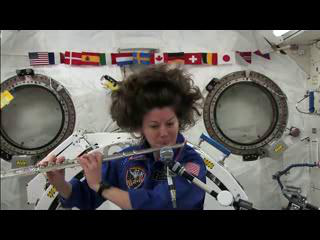

In [ ]:
Image.open(frame)

In [ ]:
#export
def get_sequence_paths(path):
    " gets all sequences folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

In [ ]:
files = get_sequence_paths(IMAGE_PATH)
files[0:3]

(#3) [Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g03_c03')]

In [ ]:
#export
class ImageTuple(Tuple):
    "An Image tuple class of arbitrary lenght"
    @classmethod
    def create(cls, fns):
        return cls(tuple(PILImage.create(f) for f in fns))

    def show(self, ctx=None, **kwargs):
        "shows 1st middle and last images of the seq"
        n = len(self)
        for t in self:
            if not isinstance(t, Tensor):
                return ctx
        return show_image(torch.cat((self[0], self[n//2], self[-1]) , dim=2), ctx=ctx, figsize=(6,3),**kwargs)

We have to sort file names to get the right sequence:

In [ ]:
ll = L('1 23 2 3 5 10 9 11'.split())

In [ ]:
# does not work
ll.sorted()

(#8) ['1','10','11','2','23','3','5','9']

In [ ]:
ll.sorted(key=int)

(#8) ['1','2','3','5','9','10','11','23']

Let's sort by the filename (without the .jpg)

In [ ]:
it = ImageTuple.create(files[0].ls().sorted(key=lambda f: int(f.name.split('.')[0])))

We have a nice method show!

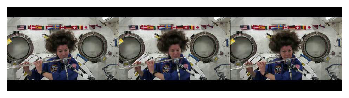

In [ ]:
ToTensor()(it).show();

We can do similar to the siamese turorial on fastai2.

In [ ]:
#export
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [ ]:
#export
def get_tuple_files(files):
    "Get a list of tuple paths"
    def sort_sequence(seq_path):
        return L(seq_path.ls().sorted(key=lambda f: int(f.with_suffix('').name)))
    return files.map(sort_sequence)

This is probably not optimal but it does the job

In [ ]:
tuples_files = get_tuple_files(files)

In [ ]:
tuples_files[0]

(#163) [Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/0.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/1.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/2.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/3.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/4.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/5.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/6.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/7.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/8.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/9.jpg')...]

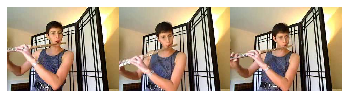

In [ ]:
ToTensor()(ImageTuple.create(tuples_files[7][0:40])).show();

to get the labels we can use a grand parent labeller:

In [ ]:
#export
def make_sequences(tuples_files, seq_len=40):
    "slice sequences to `seq_len`"
    return L(tups[0:seq_len] for tups in tuples_files)

In [ ]:
make_sequences(tuples_files)

(#13320) [(#40) [Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/0.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/1.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/2.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/3.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/4.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/5.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/6.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/7.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/8.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01/9.jpg')...],(#40) [Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02/0.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02/1.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02/2.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02/3.jpg'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02/4.jpg

## Dataset

Pure Pytorch dataset approach

In [ ]:
#export
def sort_files(path_seq):
    return path_seq.sorted(key=lambda f: int(f.with_suffix('').name))

We only need to create a class with :
- `__getitem__`
- `__len__`

In [ ]:
#export
class ActionDataset():
    "A wrapper to hold the data on path format"
    def __init__(self, image_path, random_sample=False, seq_len=20):
        self.sequence_paths = get_sequence_paths(image_path) 
        self.tuples_files = get_tuple_files(self.sequence_paths) if not random_sample else None
        self.seq_len = seq_len
        self.random_sample = random_sample
        
    def __getitem__(self, i):
        "Get a list of images files for item i"
        label = self.sequence_paths[i].parent.name
        if self.random_sample:
            frames = self.sequence_paths[i].ls()
            return tuple(PILImage.create(f) for f in sort_files(L(random.sample(list(frames), self.seq_len))))+(Category(label),)
        else:
            frames = self.tuples_files[i]
            n_frames = len(frames)
            first_idx = random.randint(0, n_frames-self.seq_len)
            s = slice(first_idx, first_idx+self.seq_len)
            return tuple(PILImage.create(f) for f in frames[s])+(Category(label),)
    
    def __len__(self):
        return len(self.sequence_paths)

In [ ]:
ds = ActionDataset(IMAGE_PATH, random_sample=True)

In [ ]:
ds[8]

(PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 'PlayingFlute')

## fastai2 Transform pipeline

In [ ]:
#export
class TupleImage(Tuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-2]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [ ]:
#export
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, random_sample=False, seq_len=20):
        self.seq_len = seq_len
        self.random_sample = random_sample
        
    def encodes(self, path):
        "Get a list of images files for folder path"
        if self.random_sample:
            frames = path.ls()
            return TupleImage(tuple(PILImage.create(f) for f in sort_files(L(random.sample(list(frames), self.seq_len)))))
        else:
            frames = sort_files(path.ls())
            n_frames = len(frames)
            first_idx = random.randint(0, n_frames-self.seq_len)
            s = slice(first_idx, first_idx+self.seq_len)
            return TupleImage(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
tfm = ImageTupleTfm()

In [ ]:
tfm.encodes(files[0])

(PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240,
 PILImage mode=RGB size=320x240)

In [ ]:
splits = RandomSplitter()(files)

In [ ]:
tfm = Pipeline([parent_label, Categorize()])

In [ ]:
files[0]

Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01')

In [ ]:
ds = Datasets(files, tfms=[[ImageTupleTfm], [parent_label, Categorize]], splits=splits)

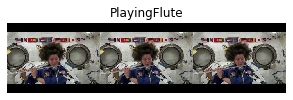

In [ ]:
ds.show(ds[0]);

In [ ]:
dls = ds.dataloaders(bs=16, after_item=[Resize(128), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
b = dls.one_batch()

In [ ]:
len(b)

2

In [ ]:
b[-1][0]

tensor(84, device='cuda:0')

In [ ]:
dls._types

{tuple: [{__main__.TupleImage: [fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage]},
  fastai2.torch_core.TensorCategory]}

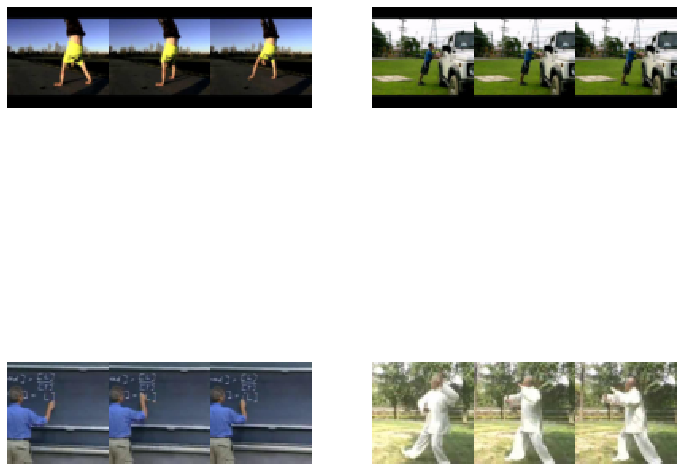

In [ ]:
dls.show_batch()

## Splits

Read the splits

In [ ]:
#export
def get_split(split_file=SPLIT_PATH/'testlist01.txt', image_path=IMAGE_PATH):
    "return split from file"
    return L(image_path/(Path(f)).with_suffix('') for f in pd.read_csv(split_file, header=None, names=['fname']).fname)

In [ ]:
split0 = get_split()

In [ ]:
files

(#13320) [Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g20_c01'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g23_c02'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g03_c03'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g13_c05'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g25_c04'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g04_c05'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g06_c06'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g10_c04'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g25_c06'),Path('UCF-101-frames/PlayingFlute/v_PlayingFlute_g15_c05')...]

In [ ]:
split0

(#3783) [Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c06'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c01'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c02'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c03'),Path('UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c04')...]

In [ ]:
#slow
idx = [i for i,x in enumerate(files) if x in split0]

In [ ]:
#export
def get_split_idxs(split_file=SPLIT_PATH/'testlist01.txt', image_path=IMAGE_PATH):
    "return indexes of split_list on files"
    split_list = get_split(split_file, image_path)
    files = get_sequence_paths(image_path)
    return [i for i,x in enumerate(files) if x in split_list]

In [ ]:
#slow
split0_idxs = get_split_idxs()

## Final Refactor

In [ ]:
#export
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, random_sample=False):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(random_sample=random_sample, seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                          after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    return dls

In [ ]:
dls = get_action_dataloaders(files, val_idxs=split0_idxs)

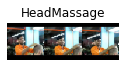

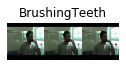

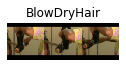

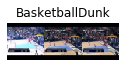

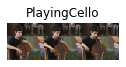

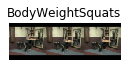

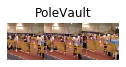

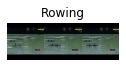

In [ ]:
dls.show_batch()

## get_action_dataloader from custom DataBlock

In [ ]:
#export
def grand_parent_label(o, **kwargs):
    "Label `item` with the gparent folder name."
    return o[0].parent.parent.name

In [ ]:
#export
def get_block(image_size=64, seq_len=40, val_idxs=None):
    "A block for sequence of images from file path list"
    item_tfms = [] if (image_size == None) else [Resize(image_size)]
    block = DataBlock(blocks    = (ImageTupleBlock, CategoryBlock),
                      get_items = partial(make_sequences, seq_len=seq_len),
                      get_y     = grand_parent_label,
                      item_tfms = item_tfms,
                      splitter  = IndexSplitter(val_idxs),
                      batch_tfms=[Normalize.from_stats(*imagenet_stats)])
    return block

In [ ]:
block = get_block()
dls = block.dataloaders(tuples_files, bs=2)

In [ ]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage,


We want to be able to show batch, we have to create a typed method for `ImageTuple`

In [ ]:
#export
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

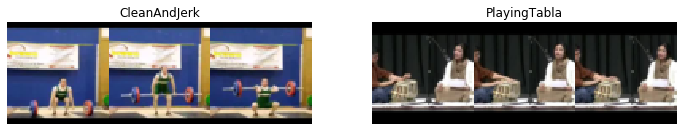

In [ ]:
dls.show_batch()

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 03_models.ipynb.
Converted 04_train_baseline.ipynb.
Converted 04_train_convlstm.ipynb.
Converted index.ipynb.
